1. 跳元模型
    * 1.1 嵌入层
    * 1.2 定义前向传播
2. 训练
    * 2.1. 二元交叉熵损失，比普通的交叉熵损失套了一层sigmoid
    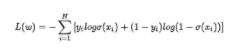
    * 2.2. 初始化模型参数
    * 2.3. 定义训练阶段代码
3. 应用词嵌入
    * 3.1. 利用余弦相似度获取相近词：
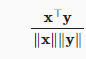
4. 小结

In [16]:
import math
import torch
from torch import nn
import dltools


batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = dltools.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [17]:
for batch in data_iter:
    break

In [18]:
batch

(tensor([[1100],
         [1413],
         [2642],
         [ 826],
         [ 142],
         [  33],
         [   1],
         [2050],
         [5025],
         [   0],
         [1185],
         [ 444],
         [ 677],
         [1062],
         [ 950],
         [ 354],
         [ 168],
         [4530],
         [ 428],
         [ 176],
         [2896],
         [1166],
         [ 519],
         [   2],
         [ 239],
         [6479],
         [ 452],
         [  46],
         [ 363],
         [  82],
         [ 217],
         [4962],
         [ 183],
         [  58],
         [ 772],
         [1794],
         [6272],
         [   9],
         [1643],
         [2596],
         [2334],
         [ 134],
         [   6],
         [ 569],
         [3401],
         [ 424],
         [  29],
         [ 158],
         [1788],
         [ 170],
         [ 746],
         [1066],
         [1229],
         [2082],
         [2280],
         [3460],
         [ 960],
         [2133],
         [  67

In [20]:
# 嵌入层
# 通过嵌入层来实现skip-gram的中心词向量和上下文词向量. 
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
# num_embeddings就是词表大小
# X: (batch_size, num_steps) -> (batch_size, num_steps, num_embeddings(vocab_size)) (把序列从索引变成one-hot) -> (batch_size, num_steps, embed_size)

In [21]:
embed.weight.shape

torch.Size([20, 4])

In [22]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]]) # 2, 3
embed_x  = embed(x)

In [23]:
embed_x

tensor([[[-0.7572,  0.4080,  1.1912,  0.0467],
         [ 1.9074,  0.9848,  2.2786,  0.8720],
         [ 2.1543, -0.1254,  0.3751,  0.2976]],

        [[ 1.4891,  0.6178,  0.6490, -1.5142],
         [ 0.4146,  1.9805, -0.5713, -0.1309],
         [-1.2613, -1.1477,  1.3139, -0.1949]]], grad_fn=<EmbeddingBackward0>)

In [24]:
embed_x.shape

torch.Size([2, 3, 4])

In [25]:
# 构造skip-gram的前向传播
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [27]:
skip_gram(torch.ones((2, 1), dtype=torch.long), torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [31]:
# 带掩码的二元交叉熵损失
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction='none')
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [29]:
[[1.1, -2.2, 3.3, -4.4]] * 2

[[1.1, -2.2, 3.3, -4.4], [1.1, -2.2, 3.3, -4.4]]

In [34]:
# 创造假数据来测试一下
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [35]:
# 初始化模型参数, 定义两个嵌入层
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
                   nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

In [38]:
# 定义训练过程
def train(net, data_iter, lr, num_epochs, device=dltools.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
            
    net.apply(init_weights)
    
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = dltools.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    
    metric = dltools.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = dltools.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1]))
    print(f'loss {metric[0] / metric[1]: .3f}', f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss  0.288 2092596.1 tokens/sec on cuda:0


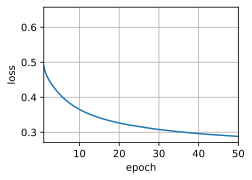

In [41]:
lr, num_epochs = 0.002, 50
train(net, data_iter, lr, num_epochs)

In [42]:
# 如果能够找到词的近义词, 就说明训练效果不错. 
def get_similar_tokens(query_token, k, embed):
    # 词向量权重拿出来
    W = embed.weight.data
    print(f'W的shape: {W.shape}')
    x = W[vocab[query_token]]
    print(f'x的shape: {x.shape}')
    # 计算余弦相似度
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    print(f'cos的shape: {cos.shape}')
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32') # 排序选择前k个对应的索引
    for i in topk[1:]: 
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [47]:
get_similar_tokens('food', 3, net[0])

W的shape: torch.Size([6719, 100])
x的shape: torch.Size([100])
cos的shape: torch.Size([6719])
cosine sim=0.418: tires
cosine sim=0.393: health-care
cosine sim=0.391: dozen
